In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import dummy
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from IPython.display import Image  
import pydotplus
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [2]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [4]:
#First, convert Ingredients column values from list of ingredients to a string containing all of the words
recipe.ingredients = recipe.ingredients.apply(lambda x: ' '.join(x))
recipe.head()

,cuisine,id,ingredients
0,chinese,45887,low sodium soy sauce fresh ginger dry mustard ...
1,thai,2941,sugar hot chili asian fish sauce lime juice
2,vietnamese,8152,soy sauce vegetable oil red bell pepper chicke...
3,thai,13121,pork loin roasted peanuts chopped cilantro fre...
4,chinese,29630,sesame seeds red pepper yellow peppers water e...


In [5]:
#Split dataset into X and y

X = recipe['ingredients']
y = recipe['cuisine']

In [6]:
#y = label_binarize(y, classes=["chinese","thai","japanese","korean","vietnamese"])
#n_classes = y.shape[1]

In [7]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [8]:
# Use CountVectorizer, including 1-grams and 2-grams.
vect = CountVectorizer(ngram_range=(1, 4), min_df=1, strip_accents=ascii)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_train_dtm.shape

(5467, 147812)

In [9]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8151398793198025


In [10]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.82      0.91      0.86       683
    japanese       0.84      0.83      0.83       376
      korean       0.83      0.73      0.78       199
        thai       0.79      0.81      0.80       353
  vietnamese       0.79      0.58      0.67       212

   micro avg       0.82      0.82      0.82      1823
   macro avg       0.81      0.77      0.79      1823
weighted avg       0.82      0.82      0.81      1823



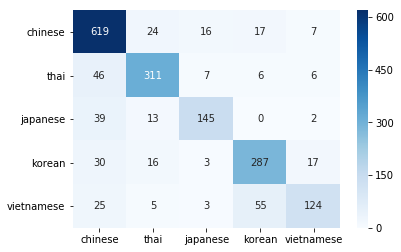

In [11]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

In [12]:
y_test_proba = logreg.predict_proba(X_test_dtm)
y_test_proba

array([[5.72844023e-01, 3.84272687e-01, 3.07059717e-02, 8.77397109e-03,
        3.40334698e-03],
       [8.73279800e-01, 1.46211415e-02, 8.02861510e-02, 4.16759901e-03,
        2.76453082e-02],
       [9.19124671e-01, 4.61713957e-02, 1.34382103e-03, 1.75050280e-02,
        1.58550837e-02],
       ...,
       [1.04934674e-01, 8.92847853e-01, 6.28974985e-04, 5.36669846e-05,
        1.53483109e-03],
       [1.69672179e-04, 4.54885943e-02, 4.08272509e-04, 7.62728076e-01,
        1.91205385e-01],
       [1.65015138e-01, 7.91471529e-01, 2.27090651e-02, 3.04495554e-03,
        1.77593132e-02]])

In [13]:
type(y_test_proba)

numpy.ndarray

In [14]:
y_test_proba_chinese = np.delete(y_test_proba, [1,2,3,4], 1)
y_test_proba_chinese

array([[5.72844023e-01],
       [8.73279800e-01],
       [9.19124671e-01],
       ...,
       [1.04934674e-01],
       [1.69672179e-04],
       [1.65015138e-01]])

In [15]:
y_test_chinese = y_test.replace("chinese", 1)
y_test_chinese = y_test_chinese.replace("korean", 0)
y_test_chinese = y_test_chinese.replace("thai", 0)
y_test_chinese = y_test_chinese.replace("vietnamese", 0)
y_test_chinese = y_test_chinese.replace("japanese", 0)
y_test_chinese

2421    1
6668    1
2689    1
5150    0
1123    0
4205    0
6799    0
2094    0
3333    1
1532    1
5006    0
3578    0
4689    0
6753    1
2951    0
6130    0
4943    0
3897    0
2945    0
3088    0
2813    0
2310    1
4415    0
4215    1
1273    1
7223    0
393     1
5982    0
3187    0
840     0
       ..
2177    1
5448    0
116     1
4953    0
4681    1
6207    0
3889    0
564     0
5392    1
6279    0
5966    1
5182    0
6558    1
775     0
5970    1
2753    0
3911    1
4194    0
3099    0
3671    0
220     0
6516    0
332     1
2954    0
6944    0
2290    1
3920    1
5203    0
1912    0
3202    1
Name: cuisine, Length: 1823, dtype: int64

In [16]:
#ROC curve

fpr_chinese, tpr_chinese, thres_chinese = roc_curve(y_test_chinese, y_test_proba_chinese)
roc_auc_chinese = auc(fpr_chinese, tpr_chinese)

#for i in range(n_classes):
#    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



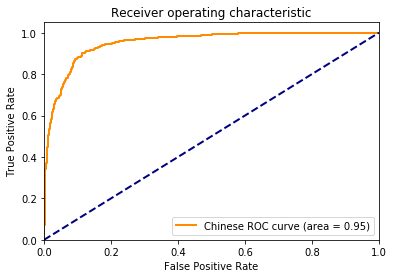

In [17]:
plt.figure()
lw = 2
plt.plot(fpr_chinese, tpr_chinese, color='darkorange',
         lw=lw, label='Chinese ROC curve (area = %0.2f)' % roc_auc_chinese)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
logreg.classes_

array(['chinese', 'japanese', 'korean', 'thai', 'vietnamese'],
      dtype=object)

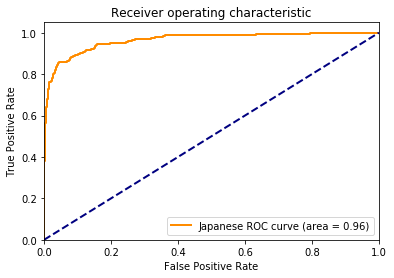

In [19]:
#Create ROC for Japanese

y_test_proba = logreg.predict_proba(X_test_dtm)
y_test_proba_japanese = np.delete(y_test_proba, [0,2,3,4], 1)
y_test_japanese = y_test.replace("chinese", 0)
y_test_japanese = y_test_japanese.replace("korean", 0)
y_test_japanese = y_test_japanese.replace("thai", 0)
y_test_japanese = y_test_japanese.replace("vietnamese", 0)
y_test_japanese = y_test_japanese.replace("japanese", 1)

fpr_japanese, tpr_japanese, thres_japanese = roc_curve(y_test_japanese, y_test_proba_japanese)
roc_auc_japanese = auc(fpr_japanese, tpr_japanese)

plt.figure()
lw = 2
plt.plot(fpr_japanese, tpr_japanese, color='darkorange',
         lw=lw, label='Japanese ROC curve (area = %0.2f)' % roc_auc_japanese)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

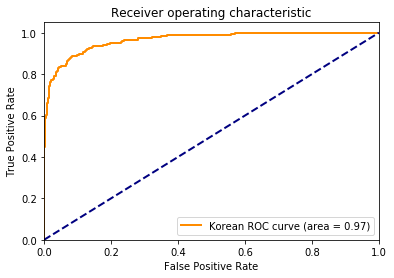

In [20]:
#Create ROC for Korean

y_test_proba = logreg.predict_proba(X_test_dtm)
y_test_proba_korean = np.delete(y_test_proba, [0,1,3,4], 1)
y_test_korean = y_test.replace("chinese", 0)
y_test_korean = y_test_korean.replace("korean", 1)
y_test_korean = y_test_korean.replace("thai", 0)
y_test_korean = y_test_korean.replace("vietnamese", 0)
y_test_korean = y_test_korean.replace("japanese", 0)

fpr_korean, tpr_korean, thres_korean = roc_curve(y_test_korean, y_test_proba_korean)
roc_auc_korean = auc(fpr_korean, tpr_korean)

plt.figure()
lw = 2
plt.plot(fpr_korean, tpr_korean, color='darkorange',
         lw=lw, label='Korean ROC curve (area = %0.2f)' % roc_auc_korean)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

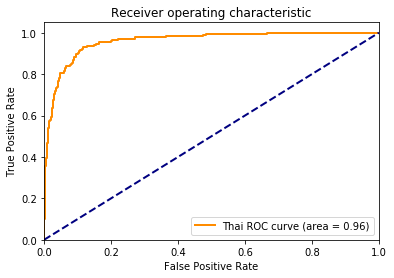

In [21]:
#Create ROC for Thai

y_test_proba = logreg.predict_proba(X_test_dtm)
y_test_proba_thai = np.delete(y_test_proba, [0,1,2,4], 1)
y_test_thai = y_test.replace("chinese", 0)
y_test_thai = y_test_thai.replace("korean", 0)
y_test_thai = y_test_thai.replace("thai", 1)
y_test_thai = y_test_thai.replace("vietnamese", 0)
y_test_thai = y_test_thai.replace("japanese", 0)

fpr_thai, tpr_thai, thres_thai = roc_curve(y_test_thai, y_test_proba_thai)
roc_auc_thai = auc(fpr_thai, tpr_thai)

plt.figure()
lw = 2
plt.plot(fpr_thai, tpr_thai, color='darkorange',
         lw=lw, label='Thai ROC curve (area = %0.2f)' % roc_auc_thai)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

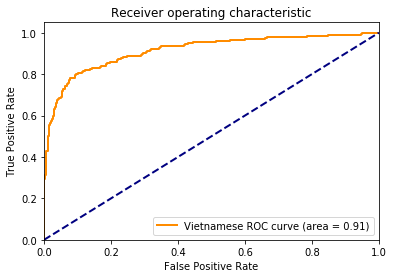

In [22]:
#Create ROC for Vietnamese

y_test_proba = logreg.predict_proba(X_test_dtm)
y_test_proba_vietnamese = np.delete(y_test_proba, [0,1,2,3], 1)
y_test_vietnamese = y_test.replace("chinese", 0)
y_test_vietnamese = y_test_vietnamese.replace("korean", 0)
y_test_vietnamese = y_test_vietnamese.replace("thai", 0)
y_test_vietnamese = y_test_vietnamese.replace("vietnamese", 1)
y_test_vietnamese = y_test_vietnamese.replace("japanese", 0)

fpr_vietnamese, tpr_vietnamese, thres_vietnamese = roc_curve(y_test_vietnamese, y_test_proba_vietnamese)
roc_auc_vietnamese = auc(fpr_vietnamese, tpr_vietnamese)

plt.figure()
lw = 2
plt.plot(fpr_vietnamese, tpr_vietnamese, color='darkorange',
         lw=lw, label='Vietnamese ROC curve (area = %0.2f)' % roc_auc_vietnamese)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

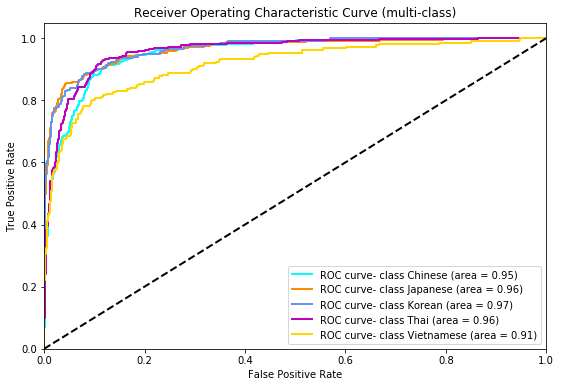

In [26]:
plt.figure(figsize=(9,6))
plt.plot(fpr_chinese, tpr_chinese, color='aqua', lw=lw,
             label='ROC curve- class Chinese (area = {1:0.2f})'
             ''.format('chinese', roc_auc_chinese))
plt.plot(fpr_japanese, tpr_japanese, color='darkorange', lw=lw,
             label='ROC curve- class Japanese (area = {1:0.2f})'
             ''.format('japanese', roc_auc_japanese))
plt.plot(fpr_korean, tpr_korean, color='cornflowerblue', lw=lw,
             label='ROC curve- class Korean (area = {1:0.2f})'
             ''.format('korean', roc_auc_korean))
plt.plot(fpr_thai, tpr_thai, color='m', lw=lw,
             label='ROC curve- class Thai (area = {1:0.2f})'
             ''.format('thai', roc_auc_thai))
plt.plot(fpr_vietnamese, tpr_vietnamese, color='gold', lw=lw,
             label='ROC curve- class Vietnamese (area = {1:0.2f})'
             ''.format('vietnamese', roc_auc_vietnamese))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (multi-class)')
plt.legend(loc="lower right")
plt.show()

In [27]:
X_train_dtm

<5467x147812 sparse matrix of type '<class 'numpy.int64'>'
	with 439110 stored elements in Compressed Sparse Row format>

In [28]:
print((vect.get_feature_names()[-50:]))

['zucchini sesame oil gochujang', 'zucchini sesame oil onions', 'zucchini sesame oil salt', 'zucchini shallots', 'zucchini shallots diced', 'zucchini shallots diced tomatoes', 'zucchini shrimp', 'zucchini sliced', 'zucchini sliced mushrooms', 'zucchini sliced mushrooms white', 'zucchini soybean', 'zucchini soybean paste', 'zucchini soybean paste shiitake', 'zucchini soybean paste tofu', 'zucchini soybean sprouts', 'zucchini soybean sprouts ground', 'zucchini squid', 'zucchini squid cabbage', 'zucchini squid cabbage olive', 'zucchini sriracha', 'zucchini sriracha sesame', 'zucchini sriracha sesame oil', 'zucchini sweet', 'zucchini sweet and', 'zucchini sweet and sour', 'zucchini tamari', 'zucchini tamari soy', 'zucchini tamari soy sauce', 'zucchini thai', 'zucchini thai green', 'zucchini thai green curry', 'zucchini toasted', 'zucchini toasted sesame', 'zucchini toasted sesame seeds', 'zucchini turnips', 'zucchini turnips carrots', 'zucchini turnips carrots white', 'zucchini unsalted', 

In [30]:
#Pickle my model so I can use it in my API
import pickle
with open('pickled_recipe_model.pkl', 'wb') as picklefile:
    pickle.dump(logreg, picklefile)

In [45]:
#Pickle my vectorizer so that I can use it for API input
with open('pickled_recipe_vectorizer.pkl', 'wb') as picklefile:
    pickle.dump(vect, picklefile)

In [44]:
logreg.predict_proba(vect.transform(['sesame oil chicken mirin soy sauce green onions']))
#logreg.predict_proba
#(np.array(['zucchini sesame oil gochujang', 'zucchini sesame oil onions']).reshape(1,-1))

array([[0.12172258, 0.79657964, 0.06370528, 0.01068196, 0.00731054]])